# CodeX: AI-Powered Hyperlocal Climate Risk Alert & Guidance System (Prototype)

**Goal**: A prototype that

1) fetches weather data for Indian districts,

2) creates a baseline label,

3) trains a model to predict risk, and

4) generates multilingual, personalized alerts via SMS.

In [2]:
!pip install requests pandas numpy scikit-learn matplotlib twilio --quiet
!pip install googletrans==4.0.0rc1 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-genai 1.30.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.13.3 which is incompatible.
openai 1.99.9 requires httpx<1,>=0.23.0, but you have httpx 

In [54]:
!pip install geopandas shapely

import geopandas as gpd
import pandas as pd

# Load India level-2 (districts) from GADM
url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_IND_2.json"
gdf = gpd.read_file(url)

# Extract district name, state name, centroid coordinates
gdf["lat"] = gdf.centroid.y
gdf["lon"] = gdf.centroid.x

districts = gdf[["NAME_1", "NAME_2", "lat", "lon"]]  # state, district, coords
districts.columns = ["state", "district", "lat", "lon"]

districts.to_csv("districts.csv", index=False)
print("✅ districts.csv saved with", len(districts), "rows")


✅ districts.csv saved with 676 rows


/tmp/ipython-input-2208759942.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat"] = gdf.centroid.y
/tmp/ipython-input-2208759942.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon"] = gdf.centroid.x


In [105]:
import os, sys, json, time, math, textwrap, datetime as dt
from typing import List, Dict
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Twilio
try:
    from twilio.rest import Client as TwilioClient
except Exception as e:
    TwilioClient = None

pd.set_option("display.max_columns", 100)

# ==== Configuration Twilio ====
%env TWILIO_ACCOUNT_SID= YOUR_AUTH_ID
%env TWILIO_AUTH_TOKEN= YOUR_AUTH_TOKEN
%env TWILIO_FROM_NUMBER= YOUR_TWILIO_PHONE_NUMBER
# %env TWILIO_WHATSAPP_FROM=whatsapp:+14155238886  # Example Twilio sandbox
import pandas as pd

districts_df = pd.read_csv("districts.csv")   # all India districts
districts_df["name"] = districts_df["district"] + ", " + districts_df["state"]
CONFIG = {
    "districts": districts_df.to_dict(orient="records"),
    "start_days_ago": 14,
    "forecast_days": 7,
    "target_event_window_h": 72,
}


#User registry for demo (phone numbers and user types)
USERS = [
    {"name": "ASHA", "role": "household", "lang": "bn", "phone": "+911234567890", "channel": "sms", "district": "Kolkata, WestBengal"},
    # {"name": "Mita", "role": "fisher", "lang": "bn", "phone": "whatsapp:+911234567891", "channel": "whatsapp", "district": "Nagapattinam, Tamil Nadu"},
]


env: TWILIO_ACCOUNT_SID=YOUR_AUTH_ID
env: TWILIO_AUTH_TOKEN=YOUR_AUTH_TOKEN
env: TWILIO_FROM_NUMBER=YOUR_TWILIO_PHONE_NUMBER


## 1) Data Fetch (Open-Meteo API)

We use **Open-Meteo** (no API key) for hourly weather: temperature, precipitation, wind, humidity, and pressure.  
Replace with IMD/IBM Weather if available.

In [58]:
def fetch_open_meteo(lat: float, lon: float, start: str, end: str) -> pd.DataFrame:
    """
    Fetch hourly weather between start and end (ISO dates) using Open-Meteo.
    """
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": lat,
        "longitude": lon,
        "hourly": ",".join([
            "temperature_2m", "relative_humidity_2m", "precipitation", "rain",
            "wind_speed_10m", "surface_pressure"
        ]),
        "past_days": 14,
        "forecast_days": 7,
        "timezone": "auto"
    }
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    hourly = data.get("hourly", {})
    times = hourly.get("time", [])
    df = pd.DataFrame({"time": pd.to_datetime(times)})
    for key, values in hourly.items():
        if key == "time":
            continue
        df[key] = values
    return df

def build_dataset(config=CONFIG) -> pd.DataFrame:
    all_rows = []
    today = dt.date.today()
    start = (today - dt.timedelta(days=config["start_days_ago"])).isoformat()
    end = (today + dt.timedelta(days=config["forecast_days"])).isoformat()

    for d in config["districts"]:
        try:
            df = fetch_open_meteo(d["lat"], d["lon"], start, end)
            df["district"] = d["name"]
            all_rows.append(df)
            print(f"Fetched: {d['name']} — {len(df)} rows")
            time.sleep(0.4)
        except Exception as e:
            print("Fetch failed for", d, ":", e)
    if not all_rows:
        raise RuntimeError("No data fetched.")
    data = pd.concat(all_rows, ignore_index=True)
    data = data.sort_values(["district", "time"]).reset_index(drop=True)
    return data

raw = build_dataset()
raw.head()


Fetched: NicobarIslands, AndamanandNicobar — 504 rows
Fetched: NorthandMiddleAndaman, AndamanandNicobar — 504 rows
Fetched: SouthAndaman, AndamanandNicobar — 504 rows
Fetched: Anantapur, AndhraPradesh — 504 rows
Fetched: Chittoor, AndhraPradesh — 504 rows
Fetched: EastGodavari, AndhraPradesh — 504 rows
Fetched: Guntur, AndhraPradesh — 504 rows
Fetched: Krishna, AndhraPradesh — 504 rows
Fetched: Kurnool, AndhraPradesh — 504 rows
Fetched: Nellore, AndhraPradesh — 504 rows
Fetched: Prakasam, AndhraPradesh — 504 rows
Fetched: Srikakulam, AndhraPradesh — 504 rows
Fetched: Visakhapatnam, AndhraPradesh — 504 rows
Fetched: Vizianagaram, AndhraPradesh — 504 rows
Fetched: WestGodavari, AndhraPradesh — 504 rows
Fetched: Y.S.R., AndhraPradesh — 504 rows
Fetched: Anjaw, ArunachalPradesh — 504 rows
Fetched: Anjaw, ArunachalPradesh — 504 rows
Fetched: Changlang, ArunachalPradesh — 504 rows
Fetched: DibangValley, ArunachalPradesh — 504 rows
Fetched: EastKameng, ArunachalPradesh — 504 rows
Fetched: Eas

,time,temperature_2m,relative_humidity_2m,precipitation,rain,wind_speed_10m,surface_pressure,district
0,2025-08-05 00:00:00,25.2,93,0.0,0.0,1.5,944.7,"Adilabad, Telangana"
1,2025-08-05 01:00:00,25.0,94,0.0,0.0,0.4,943.9,"Adilabad, Telangana"
2,2025-08-05 02:00:00,24.7,94,0.0,0.0,0.8,943.4,"Adilabad, Telangana"
3,2025-08-05 03:00:00,24.5,94,0.0,0.0,0.0,943.4,"Adilabad, Telangana"
4,2025-08-05 04:00:00,24.3,94,0.0,0.0,0.4,943.3,"Adilabad, Telangana"


## 2) Feature Engineering

Here rolling/window features and simple climatic risk proxies is computed:

- Rolling sums of precipitation & rain
- Rolling max wind speed
- Rolling averages for humidity & pressure
- Diurnal temperature range

In [94]:
def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df = df.sort_values(["district", "time"]).reset_index(drop=True)
    group = df.groupby("district", group_keys=False)

    def fe(g):
        g = g.copy()
        for w in [6, 12, 24, 48, 72]:
            g[f"rain_sum_{w}h"] = g["rain"].rolling(w, min_periods=1).sum()
            g[f"precip_sum_{w}h"] = g["precipitation"].rolling(w, min_periods=1).sum()
            g[f"wind_max_{w}h"] = g["wind_speed_10m"].rolling(w, min_periods=1).max()
            g[f"rh_mean_{w}h"] = g["relative_humidity_2m"].rolling(w, min_periods=1).mean()
            g[f"press_mean_{w}h"] = g["surface_pressure"].rolling(w, min_periods=1).mean()
        g["temp_range_24h"] = g["temperature_2m"].rolling(24, min_periods=1).apply(lambda x: float(np.max(x)-np.min(x)))
        return g

    df = group.apply(fe)
    return df

data = engineer_features(raw)
data.head()


/tmp/ipython-input-1351752983.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = group.apply(fe)


,time,temperature_2m,relative_humidity_2m,precipitation,rain,wind_speed_10m,surface_pressure,district,rain_sum_6h,precip_sum_6h,wind_max_6h,rh_mean_6h,press_mean_6h,rain_sum_12h,precip_sum_12h,wind_max_12h,rh_mean_12h,press_mean_12h,rain_sum_24h,precip_sum_24h,wind_max_24h,rh_mean_24h,press_mean_24h,rain_sum_48h,precip_sum_48h,wind_max_48h,rh_mean_48h,press_mean_48h,rain_sum_72h,precip_sum_72h,wind_max_72h,rh_mean_72h,press_mean_72h,temp_range_24h
0,2025-08-05 00:00:00,25.2,93,0.0,0.0,1.5,944.7,"Adilabad, Telangana",0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0
1,2025-08-05 01:00:00,25.0,94,0.0,0.0,0.4,943.9,"Adilabad, Telangana",0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.2
2,2025-08-05 02:00:00,24.7,94,0.0,0.0,0.8,943.4,"Adilabad, Telangana",0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.5
3,2025-08-05 03:00:00,24.5,94,0.0,0.0,0.0,943.4,"Adilabad, Telangana",0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.7
4,2025-08-05 04:00:00,24.3,94,0.0,0.0,0.4,943.3,"Adilabad, Telangana",0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.9


## 3) Bootstrap Labels (Rule-based)

In absence of labeled ground-truth, a **proxy label** is created:
- **Flood/Heavy Rain risk** if 72h rainfall sum crosses a threshold OR 24h is extreme
- **Cyclone/Gale risk** if wind speed crosses high threshold
- Combine into **High/Medium/Low** risk classes

These labels seed a supervised model and can be replaced with NGO/government ground-truth later.

In [95]:
def label_rules(row) -> int:
    rain72 = row.get("precip_sum_72h", 0.0)
    rain24 = row.get("precip_sum_24h", 0.0)
    wind72 = row.get("wind_max_72h", 0.0)
    humidity = row.get("rh_mean_24h", 0.0)

    risk_points = 0
    if rain72 >= 80 or rain24 >= 60:
        risk_points += 2
    elif rain72 >= 40 or rain24 >= 30:
        risk_points += 1

    if wind72 >= 60:
        risk_points += 2
    elif wind72 >= 40:
        risk_points += 1

    if humidity >= 85:
        risk_points += 1

    if risk_points >= 3:
        return 2  # High
    elif risk_points == 2:
        return 1  # Medium
    else:
        return 0  # Low

data["risk_class"] = data.apply(label_rules, axis=1)

feature_cols = [c for c in data.columns if any(prefix in c for prefix in ["rain_sum_", "precip_sum_", "wind_max_", "rh_mean_", "press_mean_", "temp_range_24h"])]
feature_cols += ["temperature_2m", "relative_humidity_2m", "precipitation", "rain", "wind_speed_10m", "surface_pressure"]
feature_cols = sorted(list(dict.fromkeys(feature_cols)))

dataset = data.dropna(subset=feature_cols + ["risk_class"]).copy()
dataset.head()


,time,temperature_2m,relative_humidity_2m,precipitation,rain,wind_speed_10m,surface_pressure,district,rain_sum_6h,precip_sum_6h,wind_max_6h,rh_mean_6h,press_mean_6h,rain_sum_12h,precip_sum_12h,wind_max_12h,rh_mean_12h,press_mean_12h,rain_sum_24h,precip_sum_24h,wind_max_24h,rh_mean_24h,press_mean_24h,rain_sum_48h,precip_sum_48h,wind_max_48h,rh_mean_48h,press_mean_48h,rain_sum_72h,precip_sum_72h,wind_max_72h,rh_mean_72h,press_mean_72h,temp_range_24h,risk_class
0,2025-08-05 00:00:00,25.2,93,0.0,0.0,1.5,944.7,"Adilabad, Telangana",0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0.0,1.5,93.000000,944.70,0.0,0
1,2025-08-05 01:00:00,25.0,94,0.0,0.0,0.4,943.9,"Adilabad, Telangana",0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.0,0.0,1.5,93.500000,944.30,0.2,0
2,2025-08-05 02:00:00,24.7,94,0.0,0.0,0.8,943.4,"Adilabad, Telangana",0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.0,0.0,1.5,93.666667,944.00,0.5,0
3,2025-08-05 03:00:00,24.5,94,0.0,0.0,0.0,943.4,"Adilabad, Telangana",0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.0,0.0,1.5,93.750000,943.85,0.7,0
4,2025-08-05 04:00:00,24.3,94,0.0,0.0,0.4,943.3,"Adilabad, Telangana",0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.0,0.0,1.5,93.800000,943.74,0.9,0


## 4) Train Model (RandomForest)

Trained with a baseline **RandomForestClassifier** to predict the 3-class risk (Low/Med/High).

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Create "future risk" label
# shift risk_class 72 hours (3 days) ahead per district
dataset = dataset.sort_values(["district", "time"])
dataset["future_risk_class"] = dataset.groupby("district")["risk_class"].shift(-72)

# drop rows where don't have future labels
dataset = dataset.dropna(subset=["future_risk_class"])

y = dataset["future_risk_class"].astype(int).values


# 2. Select Features
leak_cols = ["risk_score", "risk_class", "future_risk_class", "alert", "alert_en", "alert_hi"]
non_numeric_cols = ["time", "district", "state"]

drop_cols = leak_cols + non_numeric_cols

feature_cols = [c for c in dataset.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(dataset[c])]
X = dataset[feature_cols].values

print("Features used:", feature_cols)


# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


# 4. Train Model
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)
clf.fit(X_train, y_train)

Features used: ['temperature_2m', 'relative_humidity_2m', 'precipitation', 'rain', 'wind_speed_10m', 'surface_pressure', 'rain_sum_6h', 'precip_sum_6h', 'wind_max_6h', 'rh_mean_6h', 'press_mean_6h', 'rain_sum_12h', 'precip_sum_12h', 'wind_max_12h', 'rh_mean_12h', 'press_mean_12h', 'rain_sum_24h', 'precip_sum_24h', 'wind_max_24h', 'rh_mean_24h', 'press_mean_24h', 'rain_sum_48h', 'precip_sum_48h', 'wind_max_48h', 'rh_mean_48h', 'press_mean_48h', 'rain_sum_72h', 'precip_sum_72h', 'wind_max_72h', 'rh_mean_72h', 'press_mean_72h', 'temp_range_24h']


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

Classification Report:

              precision    recall  f1-score   support

           0      0.971     0.997     0.984     47929
           1      0.975     0.880     0.925     10565
           2      0.982     0.892     0.935      2526

    accuracy                          0.972     61020
   macro avg      0.976     0.923     0.948     61020
weighted avg      0.973     0.972     0.972     61020

Macro ROC-AUC: 0.998


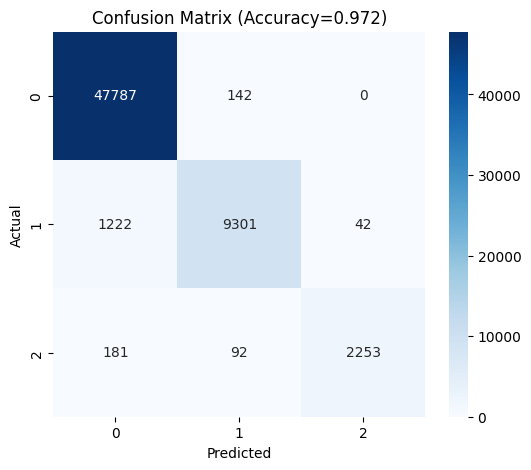

In [99]:
# 5. Predictions & Evaluation
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=3))

try:
    auc_macro = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")
    print(f"Macro ROC-AUC: {auc_macro:.3f}")
except Exception as e:
    print("AUC not computed:", e)


# 6. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Accuracy={acc:.3f})")
plt.show()

## 5) Risk Scoring

Model probabilities are converted to a **numeric risk score** (0–100), and classify into levels.

In [101]:
def risk_score_from_proba(proba_row: np.ndarray) -> float:
    return float(proba_row[1]*50 + proba_row[2]*100)

def risk_level(score: float) -> str:
    if score >= 70:
        return "HIGH"
    elif score >= 40:
        return "MEDIUM"
    return "LOW"

risk_scores = [risk_score_from_proba(p) for p in y_proba]
levels = [risk_level(s) for s in risk_scores]

eval_df = pd.DataFrame({
    "true": y_test,
    "pred": y_pred,
    "risk_score": risk_scores,
    "level": levels
})
eval_df.head()


,true,pred,risk_score,level
0,0,0,1.000000,LOW
1,0,0,3.500000,LOW
2,0,0,0.333333,LOW
3,0,0,1.833333,LOW
4,1,1,36.666667,LOW


## 6) Personalized Alerts

Alert messages are generated based on **district, state**; **risk level**; and **user profile** (role + language).    
Here lightweight Hindi/Bengali templates are included for demo.

In [77]:
TEMPLATES = {
    "en": {
        "HIGH": "⚠️ High {event} risk in {district} within 72 hours. {advice}",
        "MEDIUM": "⚠️ Moderate {event} risk in {district} within 72 hours. {advice}",
        "LOW": "ℹ️ Low {event} risk in {district}. But stay alert. {advice}",
        "advice": {
            "farmer": "Move equipment to higher ground, secure seeds/fertilizers, and cover storage.",
            "fisher": "Avoid venturing into deep sea, check local advisories, keep life jackets ready.",
            "household": "Keep essentials ready, charge phones, store clean water, and review evacuation routes."
        }
    },
    "hi": {
        "HIGH": "⚠️ अगले 72 घंटों में {district} में {event} का उच्च जोखिम। {advice}",
        "MEDIUM": "⚠️ अगले 72 घंटों में {district} में {event} का मध्यम जोखिम। {advice}",
        "LOW": "ℹ️ {district} में {event} का कम जोखिम। लेकिन सतर्क रहें। {advice}",
        "advice": {
            "farmer": "उपकरण ऊँची जगह रखें, बीज/खाद सुरक्षित करें, भंडारण ढकें।",
            "fisher": "गहरे समुद्र में न जाएँ, स्थानीय सलाह देखें, लाइफ जैकेट तैयार रखें।",
            "household": "ज़रूरी वस्तुएँ तैयार रखें, फ़ोन चार्ज रखें, स्वच्छ पानी रखें, निकासी मार्ग जानें।"
        }
    },
    "bn": {
        "HIGH": "⚠️ আগামী ৭২ ঘণ্টায় {district} এলাকায় {event} এর উচ্চ ঝুঁকি। {advice}",
        "MEDIUM": "⚠️ আগামী ৭২ ঘণ্টায় {district} এলাকায় {event} এর মাঝারি ঝুঁকি। {advice}",
        "LOW": "ℹ️ {district} এলাকায় {event} এর কম ঝুঁকি। কিন্তু সতর্ক থাকুন। {advice}",
        "advice": {
            "farmer": "যন্ত্রপাতি উঁচু জায়গায় রাখুন, বীজ/সার সুরক্ষিত করুন, স্টোরেজ ঢেকে রাখুন।",
            "fisher": "গভীর সমুদ্রে যাবেন না, স্থানীয় পরামর্শ দেখুন, লাইফ জ্যাকেট প্রস্তুত রাখুন।",
            "household": "জরুরি সামগ্রী প্রস্তুত রাখুন, ফোন চার্জ রাখুন, পরিষ্কার পানি মজুত রাখুন, নির্গমন পথ জেনে নিন।"
        }
    }
}

def make_alert(district: str, level: str, role: str="household", lang: str="en") -> str:
    lang = lang if lang in TEMPLATES else "en"
    t = TEMPLATES[lang]
    advice = t["advice"].get(role, t["advice"]["household"])
    event = "weather"  # placeholder
    base = t[level]
    return base.format(event=event, district=district, advice=advice)

print(make_alert("Gaya, Bihar", "HIGH", role="farmer", lang="hi"))
print(make_alert("Purba Medinipur, WestBengal", "MEDIUM", role="fisher", lang="bn"))
print(make_alert("Nagapattinam, Tamil Nadu", "LOW", role="household", lang="en"))

⚠️ अगले 72 घंटों में Gaya, Bihar में weather का उच्च जोखिम। उपकरण ऊँची जगह रखें, बीज/खाद सुरक्षित करें, भंडारण ढकें।
⚠️ আগামী ৭২ ঘণ্টায় Purba Medinipur, WestBengal এলাকায় weather এর মাঝারি ঝুঁকি। গভীর সমুদ্রে যাবেন না, স্থানীয় পরামর্শ দেখুন, লাইফ জ্যাকেট প্রস্তুত রাখুন।
ℹ️ Low weather risk in Nagapattinam, Tamil Nadu. But stay alert. Keep essentials ready, charge phones, store clean water, and review evacuation routes.


## 7) Batch Inference for All Districts

run model on the **latest timestamp** per district and produce an alert feed.

In [102]:
def latest_per_district(df: pd.DataFrame) -> pd.DataFrame:
    idx = df.groupby("district")["time"].idxmax()
    return df.loc[idx].copy().reset_index(drop=True)

feature_df = dataset.copy()
latest = latest_per_district(feature_df)

X_latest = latest[feature_cols].values
proba_latest = clf.predict_proba(X_latest)
latest["risk_score"] = [risk_score_from_proba(p) for p in proba_latest]
latest["level"] = [risk_level(s) for s in latest["risk_score"]]

latest["alert_en"] = [
    make_alert(district=row["district"], level=row["level"], role="household", lang="en")
    for _, row in latest.iterrows()
]

district_alerts = latest[["district", "risk_score", "level", "alert_en"]]
district_alerts.to_csv("district_alerts.csv", index=False)
print("✅ Saved alerts for ALL India districts → district_alerts.csv")

from IPython.display import display
display(district_alerts.head(20))  # preview first 20 alerts



✅ Saved alerts for ALL India districts → district_alerts.csv


,district,risk_score,level,alert_en
0,"Adilabad, Telangana",2.166667,LOW,"ℹ️ Low weather risk in Adilabad, Telangana. Bu..."
1,"AgarMalwa, MadhyaPradesh",5.666667,LOW,"ℹ️ Low weather risk in AgarMalwa, MadhyaPrades..."
2,"Agra, UttarPradesh",1.000000,LOW,"ℹ️ Low weather risk in Agra, UttarPradesh. But..."
3,"Ahmadabad, Gujarat",7.833333,LOW,"ℹ️ Low weather risk in Ahmadabad, Gujarat. But..."
4,"Ahmadnagar, Maharashtra",0.500000,LOW,"ℹ️ Low weather risk in Ahmadnagar, Maharashtra..."
5,"Aizawl, Mizoram",2.666667,LOW,"ℹ️ Low weather risk in Aizawl, Mizoram. But st..."
6,"Ajmer, Rajasthan",2.666667,LOW,"ℹ️ Low weather risk in Ajmer, Rajasthan. But s..."
7,"Akola, Maharashtra",1.666667,LOW,"ℹ️ Low weather risk in Akola, Maharashtra. But..."
8,"Alappuzha, Kerala",0.000000,LOW,"ℹ️ Low weather risk in Alappuzha, Kerala. But ..."
9,"Aligarh, UttarPradesh",0.000000,LOW,"ℹ️ Low weather risk in Aligarh, UttarPradesh. ..."


from matplotlib import pyplot as plt
_df_16['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['risk_score'].plot(kind='hist', bins=20, title='risk_score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_18.groupby('level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_19.plot(kind='scatter', x='index', y='risk_score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['risk_score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_20.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('level')):
  _plot_series(series, series_name, i)
  fig.legend(title='level', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('risk_score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('level')):
  _plot_series(series, series_name, i)
  fig.legend(title='level', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_22['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['risk_score'].plot(kind='line', figsize=(8, 4), title='risk_score')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['level'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='level', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['level'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='risk_score', y='level', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## 8) User Personalization & Routing

Map users to their districts and generate alerts in their preferred language and role.

In [ ]:
def attach_user_alerts(latest_df: pd.DataFrame, users: List[Dict]) -> pd.DataFrame:
    out_rows = []
    dmap = latest_df.set_index("district").to_dict(orient="index")

    for u in users:
        d = dmap.get(u["district"])
        if not d:
            print(f"⚠️ Warning: No data found for user {u['name']} (district='{u['district']}'). "
                  f"Available districts: {list(dmap.keys())}")
            continue
        alert = make_alert(district=u["district"], level=d["level"],
                           role=u["role"], lang=u["lang"])
        out_rows.append({
            "name": u["name"],
            "phone": u["phone"],
            "channel": u["channel"],
            "district": u["district"],
            "level": d["level"],
            "risk_score": d["risk_score"],
            "alert": alert
        })

    df = pd.DataFrame(out_rows)
    if df.empty:
        print("⚠️ No alerts generated! Double-check that USERS['district'] matches latest_df['district'].")
    else:
        from IPython.display import display
        display(df)

    return df

# Usage
user_alerts = attach_user_alerts(latest, USERS)


## 9) Send Alerts (Twilio SMS):

Fill your Twilio credentials as environment variables and run the send functions below.

In [ ]:
def twilio_client():
    if TwilioClient is None:
        print("Twilio not installed. Please install and retry.")
        return None
    sid = os.getenv("TWILIO_ACCOUNT_SID")
    token = os.getenv("TWILIO_AUTH_TOKEN")
    if not sid or not token:
        print("Set TWILIO_ACCOUNT_SID & TWILIO_AUTH_TOKEN environment variables.")
        return None
    return TwilioClient(sid, token)

def send_sms(to_number: str, body: str):
    client = twilio_client()
    if client is None:
        return
    from_number = os.getenv("TWILIO_FROM_NUMBER")
    if not from_number:
        print("Set TWILIO_FROM_NUMBER env var.")
        return
    msg = client.messages.create(to=to_number, from_=from_number, body=body)
    print("SMS sent:", msg.sid)

# def send_whatsapp(to_number: str, body: str):
#     client = twilio_client()
#     if client is None:
#         return
#     wa_from = os.getenv("TWILIO_WHATSAPP_FROM", "whatsapp:+14155238886")
#     msg = client.messages.create(to=to_number, from_=wa_from, body=body)
#     print("WhatsApp sent:", msg.sid)

# Demo (disabled by default):
for _, row in user_alerts.iterrows():
    if row["channel"] == "sms" and str(row["phone"]).startswith("+"):
        send_sms(row["phone"], row["alert"])
    # elif row["channel"] == "whatsapp" and str(row["phone"]).startswith("whatsapp:"):
    #     send_whatsapp(row["phone"], row["alert"])


## 10) Simple Risk Dashboard (Plot)

Quick view of latest district risk scores.

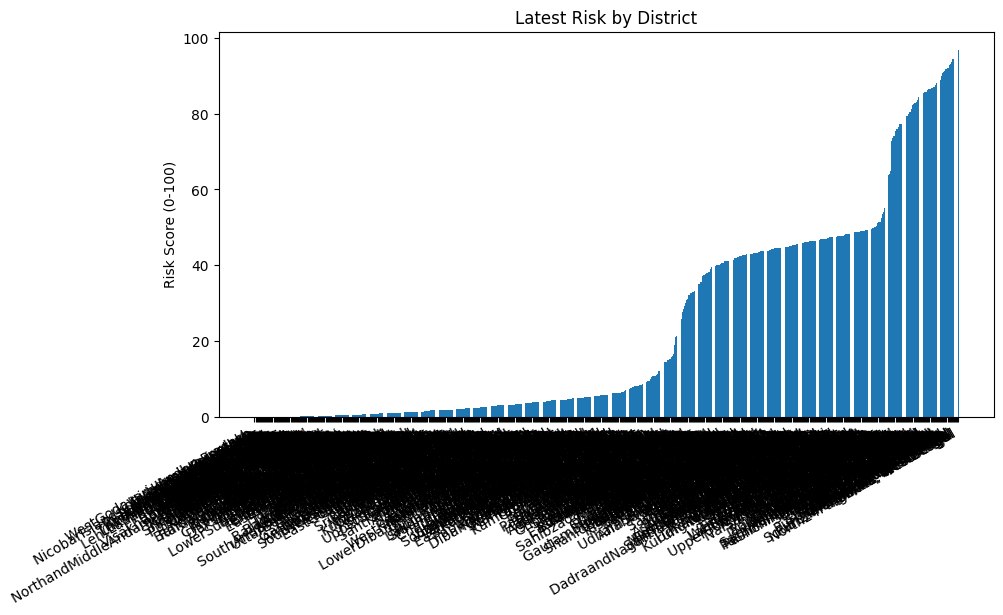

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
latest.sort_values("risk_score", inplace=True)
ax.bar(latest["district"], latest["risk_score"])
ax.set_ylabel("Risk Score (0-100)")
ax.set_title("Latest Risk by District")
plt.xticks(rotation=30, ha="right")
plt.show()


## 11) Save Results

Download CSV of district risk & user alerts.

In [ ]:
import os

latest_path = "/mnt/data/district_latest_risk.csv"
user_alerts_path = "/mnt/data/user_alerts.csv"

# Create the directory if it doesn't exist
os.makedirs('/mnt/data', exist_ok=True)

latest.to_csv(latest_path, index=False)
user_alerts.to_csv(user_alerts_path, index=False)
latest_path, user_alerts_path

In [ ]:
from google.colab import files
files.download("/mnt/data/district_latest_risk.csv")
files.download("/mnt/data/user_alerts.csv")